In [1]:
import numpy as np
#import seaborn as sns
#sns.set()
#sns.set(font_scale=1.)
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls
from itertools import product

In [2]:
expectations = np.load('zerotrackingfive.npz')

"""show the expectations available here"""
print('expectations available: {}'.format(expectations.files))

"""example for using the analysis code"""
J_field = expectations['current']
J_field_track = expectations['tracking_current']
phi = expectations['phi']
tracking_phi = expectations['tracking_phi']

expectations available: ['H', 'neighbour', 'lhopup', 'lhopdown', 'nup0', 'ndown0', 'D0', 'nup1', 'ndown1', 'D1', 'nup2', 'ndown2', 'D2', 'nup3', 'ndown3', 'D3', 'nup4', 'ndown4', 'D4', 'nup5', 'ndown5', 'D5', 'nup6', 'ndown6', 'D6', 'nup7', 'ndown7', 'D7', 'nup8', 'ndown8', 'D8', 'nup9', 'ndown9', 'D9', 'current', 'phi', 'tracking_current', 'tracking_phi', 'tracking_neighbour']


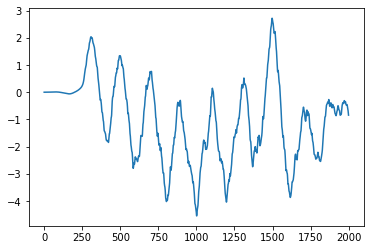

In [3]:
plt.plot(tracking_phi)
plt.show()

In [4]:
def Phi(t, f, s=0, phase=0):
    """
    Transform limited pulse 
    :param t: time
    :param f: frequency, aim for lower values
    :param s: time delay, must be positive
    :param phase: carrier wave phase delay, prefer to change s or t than phase
    :return: Transform limited pulse with enforcement of wave starting at 0
    """
    return np.sin(t - s) ** 2 * np.sin(f * (t - s) + phase) * (t > s) * (t < (s + np.pi)) 

t = np.linspace(0, np.pi, phi.size)

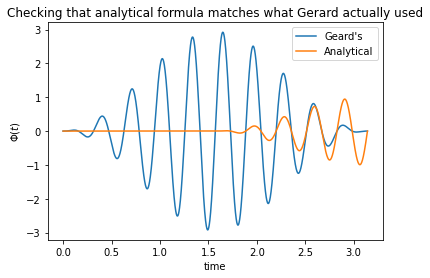

In [5]:
plt.title("Checking that analytical formula matches what Gerard actually used")
plt.plot(t, phi, label='Geard\'s')
plt.plot(t, Phi(t, 20, 0.5 * np.pi), label='Analytical')

plt.legend()
plt.ylabel('$\Phi(t)$')
plt.xlabel('time')
plt.show()

In [6]:
# number of pulses to use
n = 4

def superoscilating_pulse(t, *args):
    
    ampl = args[:n]
    phase = args[n:]
    freq = np.linspace(10, 20, n)
    
    return sum(a * Phi(t, f, s) for a, f, s in zip(ampl, phase, freq))
    

In [7]:
popt, pcov = curve_fit(
    superoscilating_pulse, 
    t, 
    tracking_phi,
    p0=np.random.rand(2 *n),
    max_nfev=10000,
    bounds=(
        np.append(np.zeros(n), t.min() * np.ones(n)),
        np.append(np.inf * np.ones(n), t.max() * np.ones(n)),
    )
)

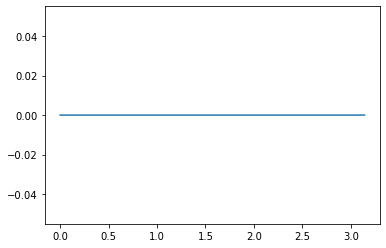

In [8]:
plt.plot(t, superoscilating_pulse(t, *popt))

In [64]:
n = 5

fields = np.array(
    [Phi(t, f, s) for f, s in product(np.linspace(0, 15, n), np.linspace(0, np.pi, 100 * n))]
).T

In [65]:
x = nnls(fields, tracking_phi)[0]

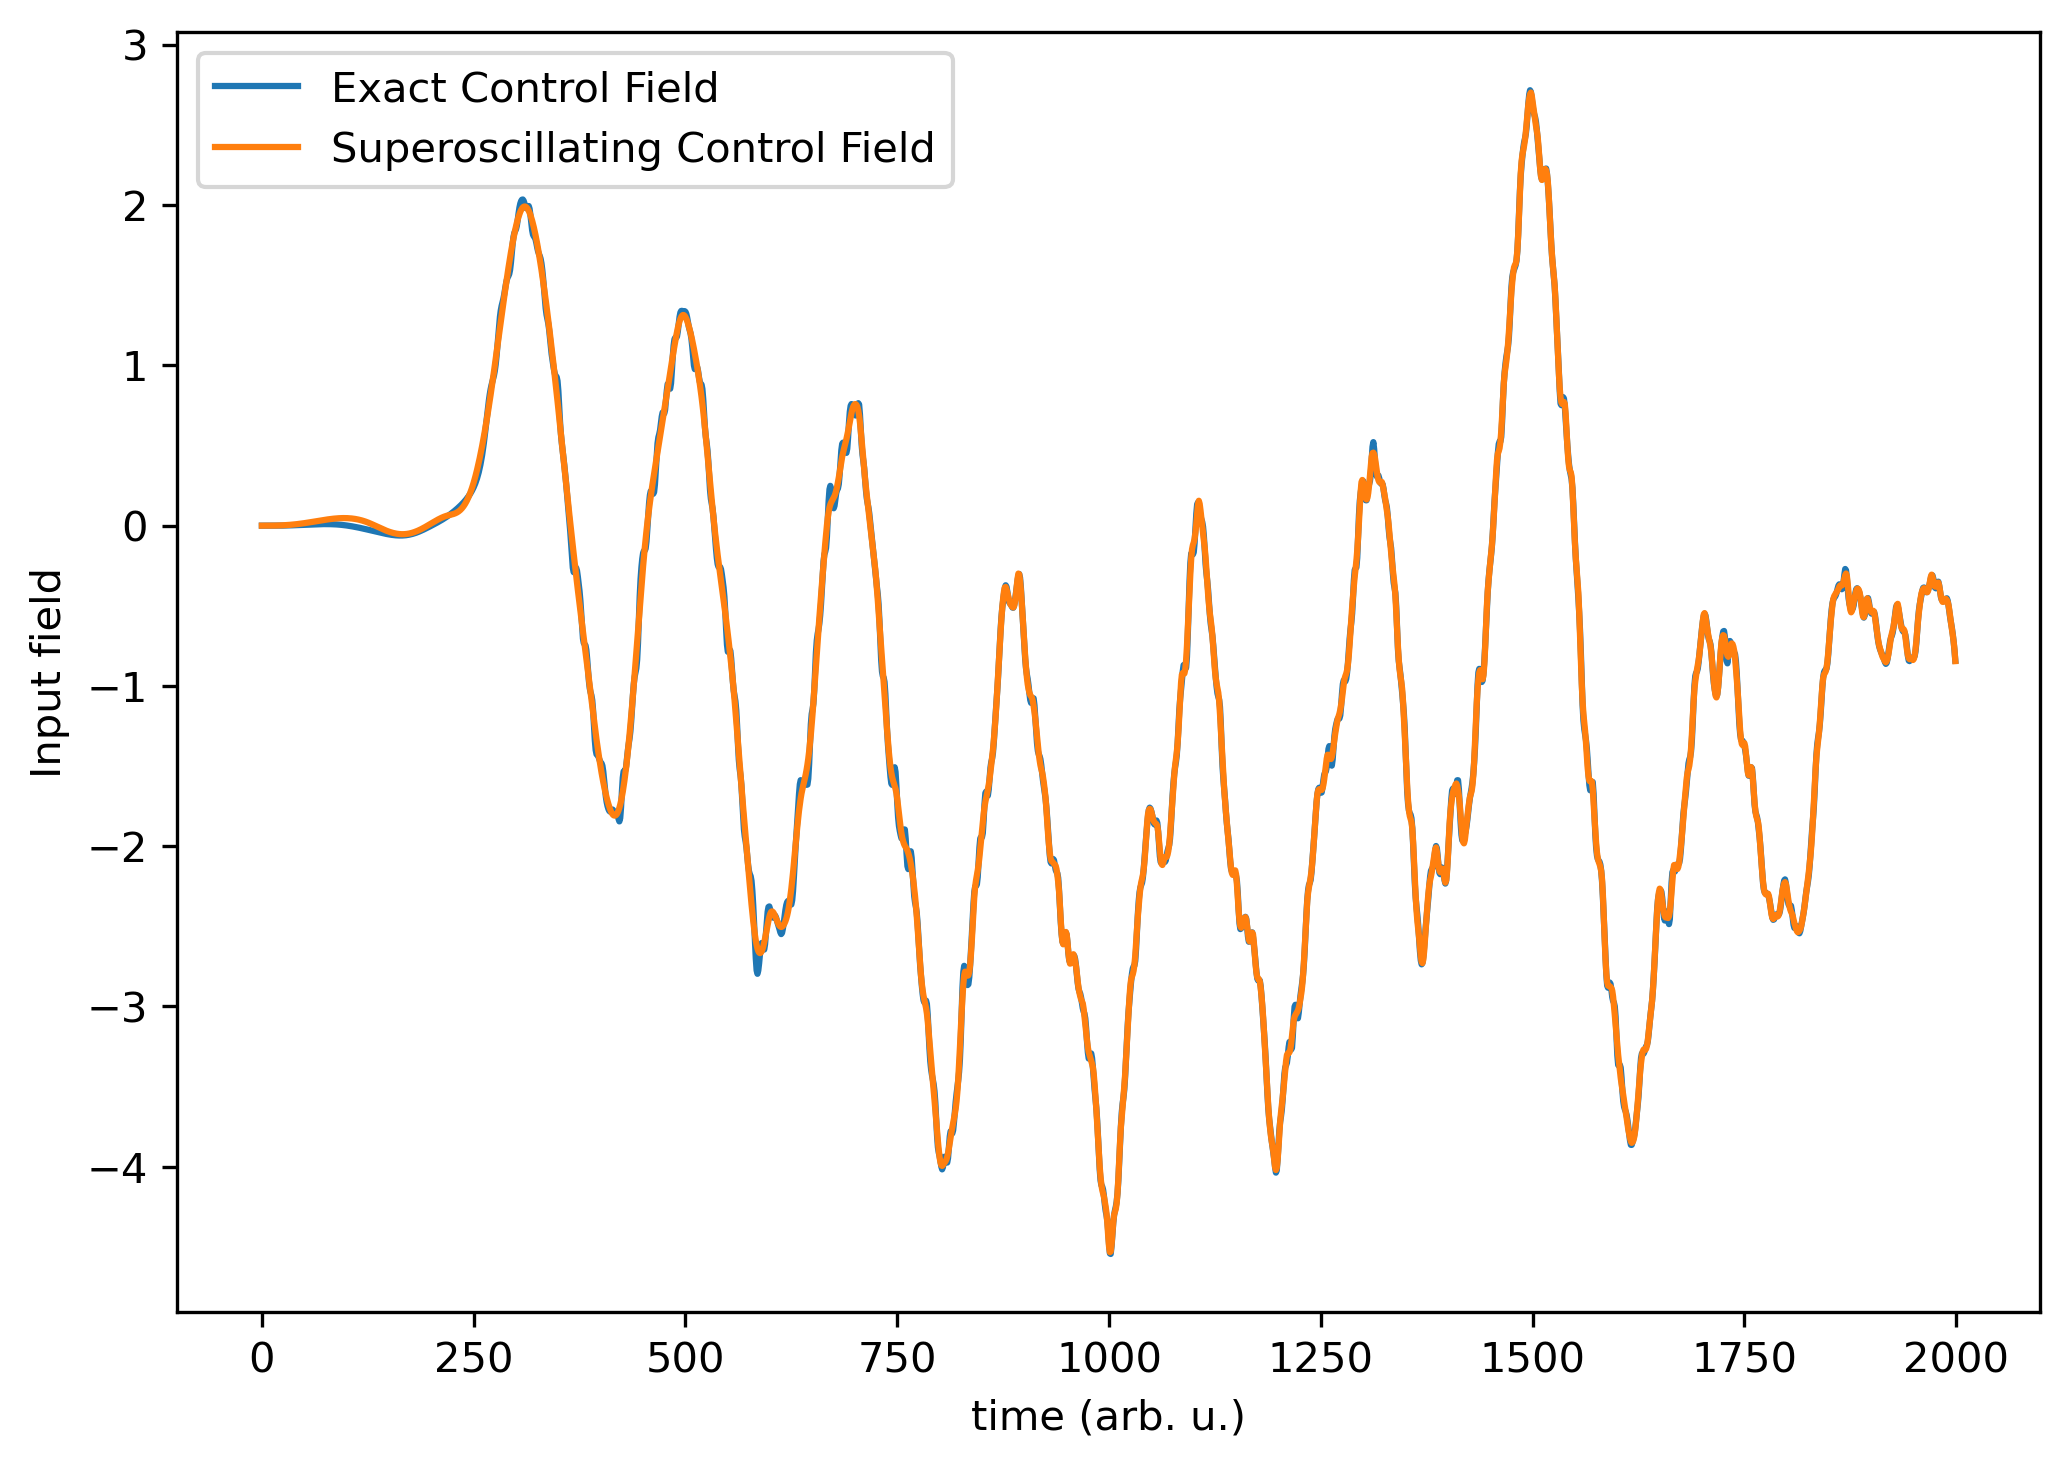

In [66]:
#plt.plot(phi, '--', color='k',label='Transform Limited Field')
plt.figure(figsize=(7, 5), dpi=300)
plt.plot(tracking_phi, label='Exact Control Field')
plt.plot(fields @ x, label='Superoscillating Control Field')

plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./FieldComparrisonPlot.pdf")
plt.show()

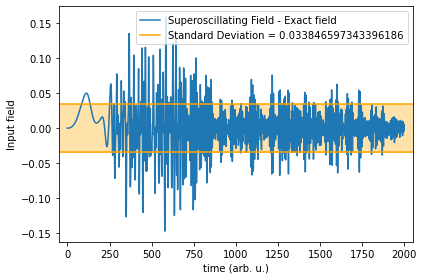

In [67]:
field_diff = (fields @ x)-tracking_phi
avg_diff = sum(field_diff) / len(field_diff)
std_dev_num = []
for n in range(0,len(field_diff)):
    std_dev_num.append((field_diff[n] + avg_diff) ** 2)
std_dev = np.sqrt(sum(std_dev_num)/len(field_diff))

plt.plot(field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(std_dev))
plt.axhline(y=-std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(field_diff)+50], -std_dev,std_dev,facecolor="orange",
            color='orange',
        alpha=0.333)

plt.legend()
plt.xlim(-50,len(field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./DifferencePlot.pdf")
plt.show()

In [68]:
out = './BestFitSCF.npz'
BestFitSCF = fields @ x
np.savez(out, field=BestFitSCF)